# Grad-Cam su modello pre-addestrato

### Dichiarazioni

In [1]:
import os,glob
import numpy as np
import cv2
import glob
import pickle
import tensorflow as tf
import argparse
import re
import datetime
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,LeakyReLU,Add,Average,Lambda,MaxPool2D,Dropout,UpSampling2D,Concatenate,Multiply,GlobalAveragePooling2D,Dense,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import concatenate,Flatten,ConvLSTM2D,MaxPooling2D,ReLU,Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog,local_binary_pattern
from skimage import data, exposure
from skimage.transform import radon, rescale
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature


## Caricamento del modello pre-addestrato in_pred

Riferimento: https://github.com/subro608/thermogram
Viene anche definito il modello in_model basato sull'architettura DenseNet121 che nel modello generale si occupa delle operazioni di convoluzione

In [2]:
from tensorflow.keras.models import load_model

in_pred = load_model('in_pred.keras')

in_model = tf.keras.applications.DenseNet121(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',classes = 2)

#viene bloccato l'aggiornamento dei pesi durante l'addestramento del modello complessivo
in_model.trainable = False
inputs = tf.keras.Input(shape=(224,224,3))

in_pred.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 4096)              205524992 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 229352002 (874.91 MB)
Trainable params: 2223144

## Preparazione del set di valutazione

Il dataset usato è il DMR-IR (http://visual.ic.uff.br/en/proeng/thiagoelias/) e contiene il ROI delle immagini in scala di grigi.
Le immagini sono opportunamente divise in "DOENTES" (sane) e "SAUDVEIS" (non sane).

Analogamente al codice usato qui https://github.com/subro608/thermogram, il set di validazione viene opportunamente diviso.
Vengono create due liste di file "affected_files_test" e "healthy_files_test" che contengono i percorsi delle immagini (.png) e dei file di testo (.txt) concatenate con un "|". La prima lista contiene i percorsi delle immagini non sane mentre la seconda contiene i percorsi delle immagini sane.

In [11]:
string = [650,700]
affected_files_text2 = []
for f in string:
    list1 = []
    normal_dir = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/{}/Segmentadas".format(f)
    normal_dir_text = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/{}/Matrizes".format(f)
    dir1 = os.path.join(normal_dir,"*.png")
    normal_files = glob.glob(dir1)
    dir2 = os.path.join(normal_dir_text,"*.txt")
    normal_files_text = glob.glob(dir2)

    try:
        for i in range(len(normal_files)):
            list1.append(normal_files[i]+"|"+normal_files_text[i])
    except:
        print(f)
            
    affected_files_text2.extend(list1)
    
string2 = [950]

healthy_files_text2 = []
for f in string2:
    list2 = []
    normal_dir = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDVEIS/{}/Segmentadas".format(f)
    normal_dir_text = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDVEIS/{}/Matrizes".format(f)
    dir1 = os.path.join(normal_dir,"*.png")
    normal_files = glob.glob(dir1)
    dir2 = os.path.join(normal_dir_text,"*.txt")
    normal_files_text = glob.glob(dir2)
    #print(len(normal_files),f)
    try:
        for i in range(len(normal_files)):
            list2.append(normal_files[i]+"|"+normal_files_text[i])
    except:
        print(f)
            
    healthy_files_text2.extend(list2)

950


In [12]:
affected_files_test = []
affected_files_test.extend(affected_files_text2)
healthy_files_test = []
healthy_files_test.extend(healthy_files_text2)

Viene creato il dizionario "test_dic" che ha come chiave i file immagini e di testo associati ai dati di validazione.

Per le immagini di pazienti sani (SAUDVEIS) viene associata l'etichetta [0,1]. Per le immagini di pazienti non sani (DOENTES) viene associata l'etichetta [1,0].

In [13]:
test_dic = {}
for f in affected_files_test:
  test_dic[f] = [1,0]
for f in healthy_files_test:
  test_dic[f] = [0,1]

In [14]:
#import random
l_test = list(test_dic.items())
#random.shuffle(l_test)

I dati vengono preparati per essere dati in input al modello.
Vengono utilizzati due operatori di rilevamento di bordi (Roberts e Sobel) per evidenziare i contorni delle immagini.  I dati saranno array NumPy di dimensione 224X224 pixel a 3 canali di colore (RGB).

test_data contiene le immagini ridimensionate e normalizzate, test_labels contiene le etichette associate a ciascuna immagine e test_text contiene una combinazione di informazioni sull'immagine originale e sulla rilevazione dei bordi.

In [15]:
test_text = []
data = []
labels = []
for i in range(len(l_test)):
    file_name,label = l_test[i]
    a,b = file_name.split("|")
    img = cv2.imread(a)
    arr_1 = np.empty((480,640))
    try:
        with open(b,"r") as f:
            arr = f.readlines()
            for i in range(len(arr)):
                arr_2 = []
                for j in arr[i].split():
                    arr_2.append(float(j))
                arr_1[i] = np.asarray(arr_2) 
        img = np.asarray(img)
        arr_1 = np.asarray(arr_1) 
        edge_roberts = roberts(arr_1)
        edge_sobel = sobel(arr_1) 
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_AREA)
        arr_img = cv2.resize(arr_1,(224,224),interpolation = cv2.INTER_CUBIC)
        s_img = cv2.resize(edge_roberts,(224,224),interpolation = cv2.INTER_CUBIC)
        r_img = cv2.resize(edge_sobel,(224,224),interpolation = cv2.INTER_CUBIC)
        arr_3 = np.expand_dims(arr_img,axis = -1)
        arr_2 = np.expand_dims(r_img,axis = -1)
        arr_1 = np.expand_dims(s_img,axis = -1)
        img2 = np.concatenate((arr_3,arr_2,arr_1),axis = -1)
        height, width = img.shape[:2]
        img2 = img2.astype('float32')/255.0
        img = img.astype('float32')/255.0
        test_text.append(img2)
        data.append(img)
        labels.append(label)

    except:
        print(i,file_name)
        print("Not possible")  
  
       
test_data = np.array(data)
print(test_data.shape)
test_text = np.array(test_text)
print(test_text.shape)
test_labels = np.array(labels)
print(test_labels.shape)    

print('^_^-testing data finished-^_^')

(61, 224, 224, 3)
(61, 224, 224, 3)
(61, 2)
^_^-testing data finished-^_^


# Grad-Cam

Per valutare il modo in cui la rete prende determinate decisioni, viene usato 
Grad-Cam per evidenziare le parti che risultano rilevanti per la decisione 
finale presa dal modello.

Individuo l'ultimo strato convoluzionale, che in questo caso corrisponde 
all'ultimo strato della rete DenseNet121 (conv5_block16_concat).
Creo un modello "last_conv_layer_model" che ha gli stessi input di in_model e come output quello dell'ultimo strato convoluzionale

In [16]:
last_conv_layer_name="conv5_block16_concat"
last_conv_layer=in_model.get_layer(last_conv_layer_name)
last_conv_layer_model=tf.keras.Model(in_model.inputs, last_conv_layer.output)
#last_conv_layer_model.summary()

Definisco un altro modello "classifier_model" che ha input nella forma (7,7,1024) provenienti da last_conv_layer_model e come output il tensore x "passato attraverso" gli strati densi definiti in classifier_layer_names.

In [17]:
classifier_layer_names = ["flatten", 
                          "dense", "dense_1", "dense_2"]
classifier_input=Input(shape=(7, 7, 1024))

#inizializzo il tensore x con gli input del nuovo modello
x=classifier_input
#applico al tensore x ogni strato denso in classifier_layer_names
for layer_name in classifier_layer_names:
    x=in_pred.get_layer(layer_name)(x)
    #creo il nuovo modello utilizzando gli input definiti in precedenza e come output x 
    #che è "passato attraverso" gli strati densi
    classifier_model=Model(classifier_input, x)

Salvo in "predizioni" una lista di tutte le predizioni effettuate dal modello sul dataset di validazione

In [18]:
predizioni=in_pred.predict(test_text)

2/2 [==============================] - 5s 2s/step


Da qui in avanti è possibile eseguire ciclicamente i codici per vedere applicato Grad-Cam su immagini casuali del set di validazione

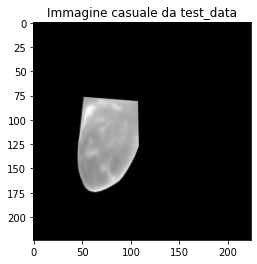

La paziente nella realtà è non sana
Il modello restituisce le seguenti probabilità: [0.9309908  0.06900916]
La paziente è classificata come non sana


In [19]:
import random
# Estrai casualmente un indice da test_data
random_index = random.randint(0, len(test_data) - 1)

# Estrai l'immagine e il label corrispondente
random_image = test_data[random_index]
random_label = test_labels[random_index]

# Visualizza l'immagine
plt.imshow(random_image[:, :, 0], cmap='gray')  # Supponendo che tu voglia visualizzare solo il primo canale
plt.title(f'Immagine casuale da test_data')
plt.show()


test_image = random_image
test_image = cv2.resize(test_image, (224, 224)) 
im=tf.constant(test_image, dtype=tf.float32)
img_array=tf.expand_dims(im, axis=0)
#print(img_array.shape)

#print(predizioni[random_index])
#print(random_label)
if np.array_equal(random_label, [0, 1]):
    print("La paziente nella realtà è sana")
else:
    print("La paziente nella realtà è non sana")

print("Il modello restituisce le seguenti probabilità: " + str(predizioni[random_index]))
output=np.argmax(predizioni[random_index])
if output==0:
    print("La paziente è classificata come non sana")
else:
    print("La paziente è classificata come sana")


In [20]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) #output ultimo strato convoluzionale
    #print(last_conv_layer_output.shape) -> (1, 7, 7, 1024)
    preds=classifier_model(last_conv_layer_output) #predizione sull'output dell'ultimo strato convoluzionale
    #print(preds)
    top_pred_index=tf.argmax(preds[0]) #identifica l'indice della classe con probabilità più alta 
    #print(top_pred_index)
    top_class_channel= preds[:, top_pred_index] #identifica la probabilità più alta (nella posizione top_pred_index)
    #print(top_class_channel)

grads=tape.gradient(top_class_channel, last_conv_layer_output)

In [21]:
pooled_grads=tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [22]:
last_conv_layer_output=last_conv_layer_output.numpy()[0]
for i in range(1024):
    last_conv_layer_output[:, :, i]*= pooled_grads[i]

In [23]:
heatmap=np.sum(last_conv_layer_output, axis=-1)

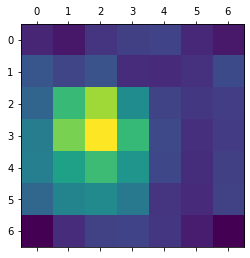

In [24]:
heatmap=tf.nn.relu(heatmap) #applico la funzione di attivazione ReLU per evidenziare solo le regioni rilevanti?
plt.matshow(heatmap)

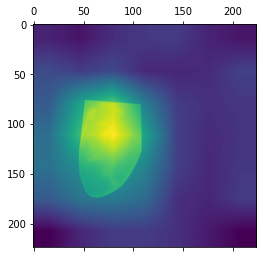

In [25]:
resized_heatmap=cv2.resize(np.array(heatmap), (224,224))
#plt.matshow(resized_heatmap)
plt.matshow(resized_heatmap*5+img_array[0,:,:,0]/255)